## Customized QCA Optimizer

In [45]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.integrate import quad
from scipy.stats import zscore
from scipy.optimize import minimize
from scipy.interpolate import interp1d

from sklearn.preprocessing import StandardScaler, MinMaxScaler, KernelCenterer
from sklearn import preprocessing
from functools import partial

import random
import networkx as nx

In [46]:
q_data_ = [np.loadtxt(f'q{i}_t1vsfreq.txt', delimiter=',') for i in range(1, 14)]
q_data = q_data_.copy()
g = [(1, 2), (1, 13), (2, 3), (2, 5), (2, 4),
    (4, 7), (4, 9), (4, 13), (5, 7), (6, 7),
    (7, 8), (8, 9), (9, 10), (9, 11), (11, 13), (12, 13)]

G = nx.Graph()
G.add_edges_from(g)
# add burning points/spanning trees
# change alpha to 3-5 alpha to obtain different solutions
D = 0.5
alpha = 0.02
beta = alpha
delta_x = 0.005
eta = {1: 0.254, 2: 0.238, 3: 0.253, 4: 0.256, 5: 0.237, 6: 0.258, 7: 0.252, 
       8: 0.251, 9: 0.245, 10: 0.237, 11: 0.247, 12: 0.247, 13: 0.239}

In [47]:
def burn_graph_from_vertex(G, starting_vertex):
    """Simulate the burning process for a graph G, starting from a given vertex."""
    burned = set([starting_vertex])
    current_burning = set([starting_vertex])
    step = 1

    while len(burned) < len(G.nodes):
        new_burning = set()
        for node in current_burning:
            # Add neighbors to be burned in the next step
            new_burning.update(set(G.neighbors(node)) - burned)

        burned.update(new_burning)
        current_burning = new_burning
        step += 1
    return step

In [48]:
def filtered_freq_and_time(one_qubit_data):
    freq, time = one_qubit_data[:,0], one_qubit_data[:,1]
    z_scores = zscore(freq)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3)  # Keeping data points with Z-score less than 3
    filtered_freq = freq[filtered_entries]
    filtered_time = time[filtered_entries]
    return filtered_freq, filtered_time


def cardinality(g, node):
    return sum(1 for edge in g if node in edge)


def most_neighbors_node(g, U):
    max_neighbors = 0
    for node in U:
        num_neighbors = cardinality(g, node)
        if num_neighbors > max_neighbors:
            max_neighbors = num_neighbors
            idx = node
        elif num_neighbors == max_neighbors:
            if burn_graph_from_vertex(G, node) < burn_graph_from_vertex(G, idx):
                idx = node
    return idx

def determined_neighbors(g, node, assigned_freqs):
    neighbors = []
    for a, b in g:
        if a == node:
            neighbors.append(b)
        elif b == node:
            neighbors.append(a) 
    neighbors = [n for n in neighbors if n in assigned_freqs.keys()]
    return neighbors

def legal_gradient(assigned_freq, one_q, gradient_threshold=0.2, distance=0.025):
    freqs, t1s = one_q
    neighbor_idx = np.where(np.abs(freqs - assigned_freq) <= distance)[0]
    if len(neighbor_idx) == 0:
        return True
    for idx in neighbor_idx:
        if idx == 0 or idx == len(freqs) - 1:
            continue
        if abs(t1s[idx+1] - t1s[idx-1]) / t1s[idx] > gradient_threshold:
            return False
    return True
    

# Neighboring constraint
def legal_neighbor(neighbors, assigned_freqs, freq):
    if neighbors == []:
        return True
    for node in neighbors:
        diff = abs(assigned_freqs[node] - freq)
        if diff > D or diff < alpha:
            return False
    return True


# Eta constraint
def legal_eta(neighbors, assigned_freqs, beta, eta_list=eta):
    if neighbors == []:
        return True
    for i, j in neighbors:
        delta_f = abs(assigned_freqs[i] - assigned_freqs[j])
        if abs(delta_f - eta_list[i]) < beta or abs(delta_f - eta_list[i] / 2) < beta:
            return False
    return True

In [49]:
def determined_neighbors(g, node, assigned_freqs):
    neighbors = []
    for a, b in g:
        if a == node:
            neighbors.append(b)
        elif b == node:
            neighbors.append(a) 
    neighbors = [n for n in neighbors if n in assigned_freqs.keys()]
    return neighbors

def legal_gradient(assigned_freq, one_q, gradient_threshold=0.2, distance=0.025):
    freqs, t1s = one_q
    neighbor_idx = np.where(np.abs(freqs - assigned_freq) <= distance)[0]
    if len(neighbor_idx) == 0:
        return True
    for idx in neighbor_idx:
        if idx == 0 or idx == len(freqs) - 1:
            continue
        if abs(t1s[idx+1] - t1s[idx-1]) / t1s[idx] > gradient_threshold:
            return False
    return True
    

# Neighboring constraint
def legal_neighbor(neighbors, assigned_freqs, freq):
    if neighbors == []:
        return True
    for node in neighbors:
        diff = abs(assigned_freqs[node] - freq)
        if diff > D or diff < alpha:
            return False
    return True


# Eta constraint
def legal_eta(neighbors, assigned_freqs, beta, eta_list=eta):
    if neighbors == []:
        return True
    for i, j in neighbors:
        delta_f = abs(assigned_freqs[i] - assigned_freqs[j])
        if abs(delta_f - eta_list[i]) < beta or abs(delta_f - eta_list[i] / 2) < beta:
            return False
    return True

In [50]:
qdata = {}
for i, one_q in enumerate(q_data.copy()):
    qdata[i+1] = filtered_freq_and_time(one_q)

## 数据平滑

In [51]:
def smooth_dataset(x_vals, y_vals, delta=0.01):
    """
    Smooths the y values by averaging over neighboring points within delta distance in x values.
    
    Returns:
    np.array: Smoothed y values.
    """
    smoothed_y = np.zeros_like(y_vals)

    for i, x in enumerate(x_vals):
        # Find all x values within delta distance of the current x point
        neighbors_idx = np.where(np.abs(x_vals - x) <= delta)[0]
        # Average the corresponding y values
        smoothed_y[i] = np.mean([y_vals[j] for j in neighbors_idx])
    return smoothed_y

In [52]:
qdata_smoothed = qdata.copy()
for i, (freq, t1) in qdata.items():
    qdata_smoothed[i] = (freq, smooth_dataset(freq, t1))

legal_freq_dots = {}
for i, one_q in qdata_smoothed.items():
    temp = []
    freqs, t1s = one_q
    for freq in freqs:
        if legal_gradient(freq, one_q):
            idx = list(freqs).index(freq)
            temp.append((freq, t1s[idx]))
    legal_freq_dots[i] = temp

# stable data points
qdata_stable = {}
for i in legal_freq_dots.keys():
    freqs, t1s = zip(*legal_freq_dots[i])
    qdata_stable[i] = (np.array(freqs), np.array(t1s))

In [53]:
def is_smooth_neighborhood(cur_pt, neighbor_pts, threshold):
    neighbor_t1_sum = sum(t1 for _, t1 in neighbor_pts)
    return (cur_pt[1] / neighbor_t1_sum) <= threshold


def points_within_radius(one_q, current_pt, radius):
    one_q = np.array(one_q).T  # Transpose the data so that each row is a point (freq, t)
    neighbors = [current_pt]
    current_freq, _ = current_pt
    for each_pt in one_q:
        if abs(each_pt[0] - current_freq) <= radius:
            neighbors.append(each_pt)
    return neighbors

    
# threshold >= 0.46, neighbor smoothed has more points than gradient stable
def smooth_neighborhood(one_q, threshold=0.05, radius=0.025):
    smooth_q = [[], []]
    freqs, t1s = one_q
    for j, (current_freq, current_t1) in enumerate(zip(freqs, t1s)):
        neighbor_pts = points_within_radius(one_q, (current_freq, current_t1), radius)
        if is_smooth_neighborhood((current_freq, current_t1), neighbor_pts, threshold):
            smooth_q[0].append(current_freq)
            smooth_q[1].append(current_t1)
    return smooth_q


# neighborhood-based smoothing technique
qdata_neighbor_smoothed = {}
for i, one_q in qdata_smoothed.items():
    qdata_neighbor_smoothed[i] = smooth_neighborhood(one_q)


# Algorithm

In [54]:
def freq_placer(g, qdata, order, params): # index starts at 1
    U = [i for i in qdata.keys()] # nodes to be assigned
    assigned_freq = {}
    assigned_t1 = {}
    exe_order = []

    while U != []:
        if order != None:
            t = order.pop(0)
        else:
            t = most_neighbors_node(g, U)
        exe_order.append(t)
        t_freq_data, t_t1_data = qdata[t]
        if assigned_freq == {}:
            max_t1 = max(t_t1_data) # can consider multiple solutions
            idx = list(t_t1_data).index(max_t1)
            assigned_freq[t] = t_freq_data[idx]
            assigned_t1[t] = max_t1
        else:
            neighbors = determined_neighbors(g, t, assigned_freq)

            candidate = [] # narrow down candidates
            for freq, t1 in zip(t_freq_data, t_t1_data):
                if legal_neighbor(neighbors, assigned_freq, freq): # and legal_eta(neighbors, assigned_freq, beta):
                    candidate.append((freq, t1))
            if candidate == []:
                print("No candidate")
                return None, None
            
            max_t1 = max([t1 for _, t1 in candidate])
            idx = list(t_t1_data).index(max_t1)
            assigned_freq[t] = t_freq_data[idx]
            assigned_t1[t] = max_t1
        
        U.remove(t)
    print("execute order", exe_order)
    return assigned_freq, assigned_t1

In [66]:
# constrain: distance to a deep gradient
# distance: +/- 0.025
# gradient_threshold: y'/y <= 0.2

def run_n_visualize(qdata, labels, list_of_orders, params=(alpha, D), g=g):
    results = []
    for opt_order in list_of_orders:
        if opt_order == "random":
            opt_order = [i+1 for i in range(len(qdata))]
            random.shuffle(opt_order)
        freqs, t1s = freq_placer(g, qdata, opt_order, params=params)
        results.append((freqs, t1s))
        if freqs == None:
            print("No solution found")
            return
    
    for i, (assigned_freq, assigned_t1) in enumerate(results):
        x_list = [i+1 for i in range(len(assigned_t1))]
        mean_T1s = {i: np.mean(qdata[i][1]) for i, _ in qdata.items()}

        y_list = [assigned_t1[i+1] - mean_T1s[i+1] for i in range(len(qdata))]
        zero_line = [0 for _ in range(len(qdata))]

        plt.plot(x_list, y_list, label=labels[i])
        print()
        print(labels[i])
        print("sum of t1: ", np.round(sum(assigned_t1.values()), 3))
        print("sum of t1 * delta x:", np.round(sum(assigned_t1.values()) * delta_x, 3), "\n")
    
    plt.plot(x_list, zero_line, label="Zero line")
    plt.title("Difference between assigned T1 and mean T1")
    plt.xlabel("Qubit index")
    plt.ylabel("Solved t1 - Mean t1")
    plt.legend()
    plt.show()

    x_labels = [f"({edge[0]}, {edge[1]})" for edge in g]
    alpha_line = [alpha for _ in range(len(g))]

    D_line = [D for _ in range(len(g))]
    for k, (assigned_freq, assigned_t1) in enumerate(results):
        freq = {i: assigned_freq[i] for i in assigned_freq.keys()}

        freq_diff = [abs(freq[j] - freq[i]) for i, j in g]
        plt.plot(x_labels, freq_diff, label = labels[k])

    plt.plot(x_labels, alpha_line, label='alpha', color='purple')
    plt.plot(x_labels, D_line, label='D', color='brown')

    # Adding labels and title
    plt.xlabel('Edges')
    plt.ylabel('Absolute Frequency Difference')
    plt.title('Adjacent Nodes vs Frequency Difference')

    plt.legend()
    plt.xticks(rotation=45, ha='right')

    pts = []
    for i in range(1, 14):
        temp = []
        for freq, t1 in results:
            temp.append([(freq[i], t1[i])])
        pts.append(temp)
    print("point", pts)
    return pts


def visualize_results(qdata, pts, labels):
    if pts == None:
        return
    for i, (freq, t1) in qdata.items():
        plt.scatter(freq, t1, color='yellow', label='Data points')
        plt.title(f'Qubit {i} T1 vs Frequency')

        for j, dots in enumerate(pts[i-1]):
            plt.scatter(dots[0][0], dots[0][1], label=labels[j])
        plt.xlabel('Frequency (GHz)')
        plt.ylabel('T1 (ms)')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

execute order [4, 2, 7, 9, 13, 1, 5, 8, 11, 3, 6, 10, 12]
execute order [7, 13, 4, 8, 9, 12, 10, 5, 3, 2, 1, 6, 11]
execute order [4, 9, 2, 7, 13, 8, 5, 11, 1, 10, 6, 3, 12]
execute order [6, 3, 12, 10, 7, 9, 13, 2, 8, 5, 1, 11, 4]

burning
sum of t1:  1883.234
sum of t1 * delta x: 9.416 


random
sum of t1:  1889.72
sum of t1 * delta x: 9.449 


center first
sum of t1:  1883.234
sum of t1 * delta x: 9.416 


edge first
sum of t1:  1883.234
sum of t1 * delta x: 9.416 



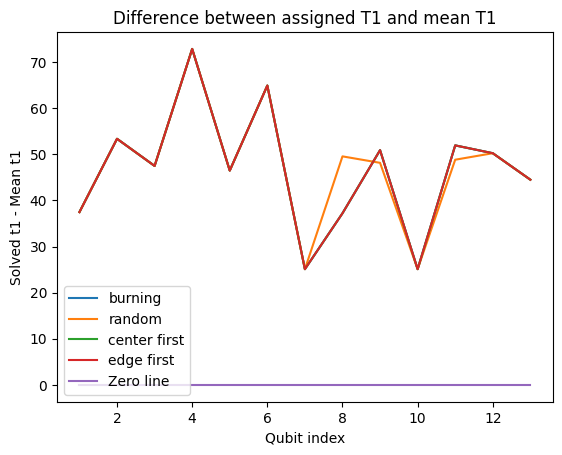

point [[[(np.float64(4.478), np.float64(146.08196))], [(np.float64(4.478), np.float64(146.08196))], [(np.float64(4.478), np.float64(146.08196))], [(np.float64(4.478), np.float64(146.08196))]], [[(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))]], [[(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))]], [[(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))]], [[(np.float64(4.2373), np.float64(138.53322000000003))], [(np.float64(4.2373), np.float64(138.53322000000003))], [(np.float64(4.2373), np.float64(138.53322000000003)

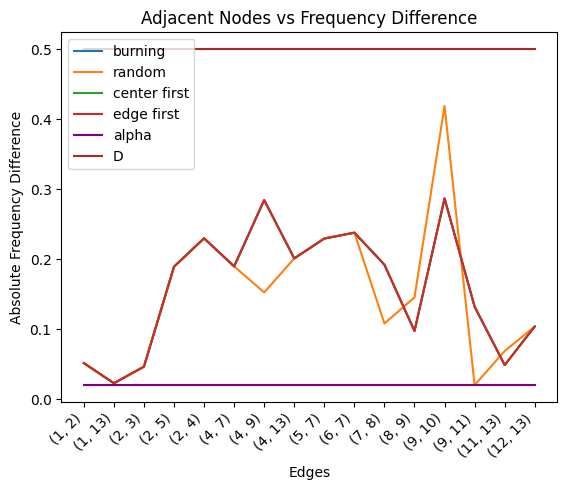

In [67]:
order_list = [None, "random", [4, 9, 2, 7, 13, 8, 5, 11, 1, 10, 6, 3, 12], [6, 3, 12, 10, 7, 9, 13, 2, 8, 5, 1, 11, 4]]
labels =["burning", "random", "center first", "edge first"]
points = run_n_visualize(qdata_neighbor_smoothed, labels, order_list)

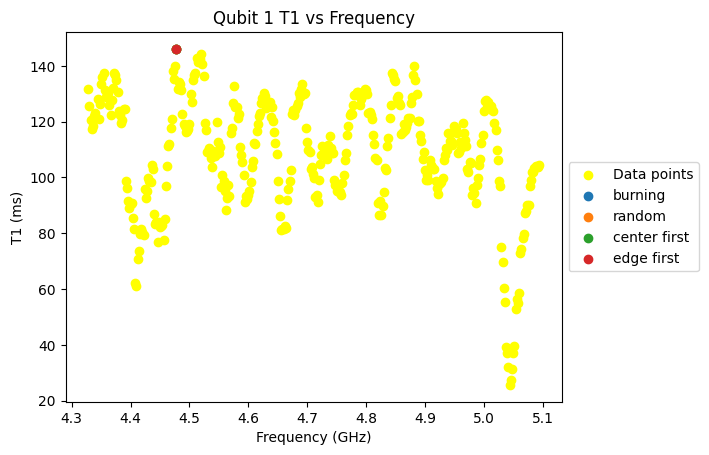

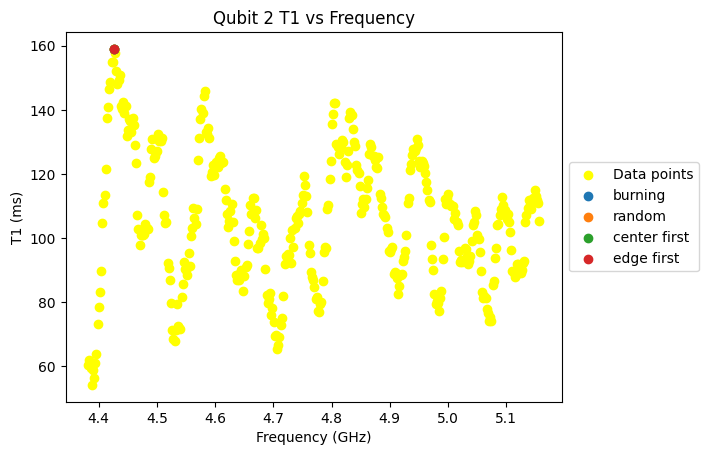

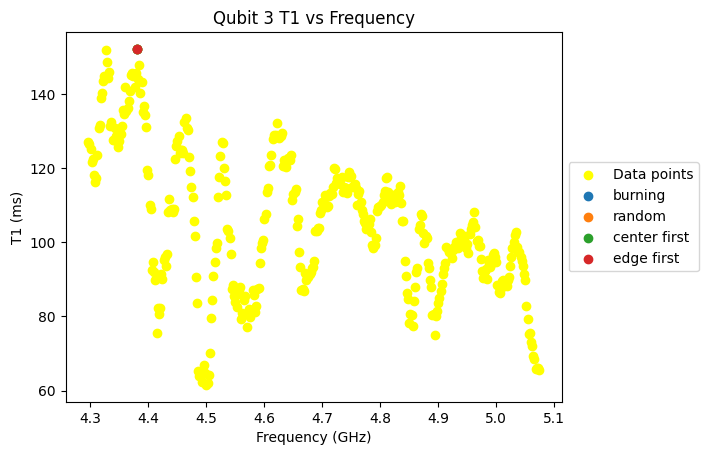

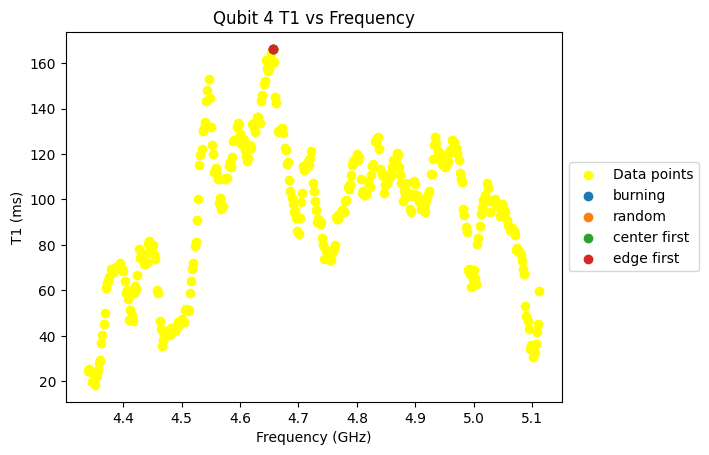

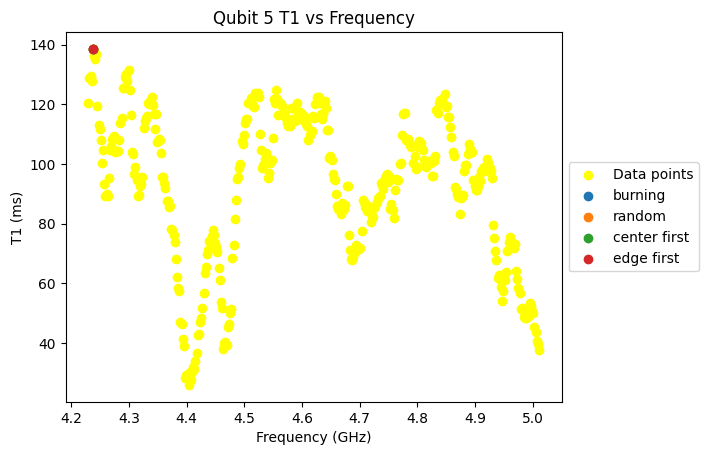

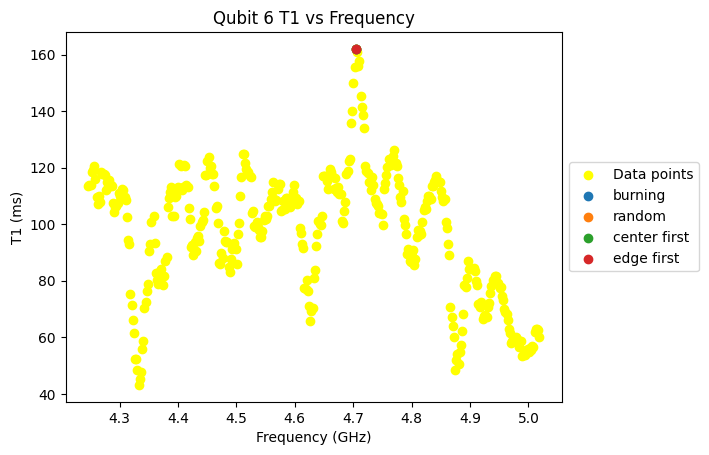

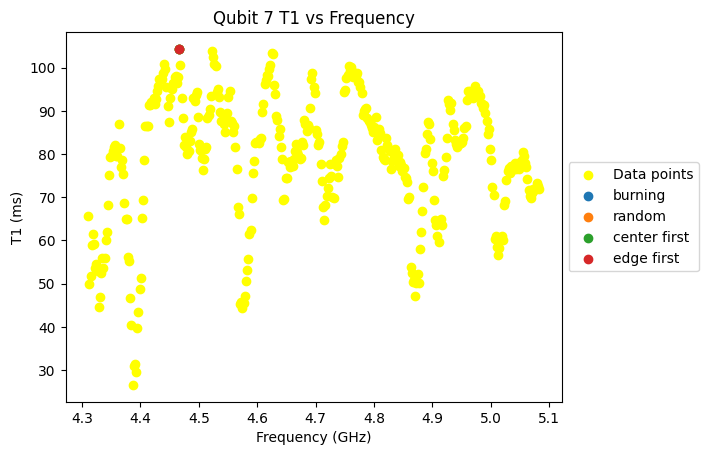

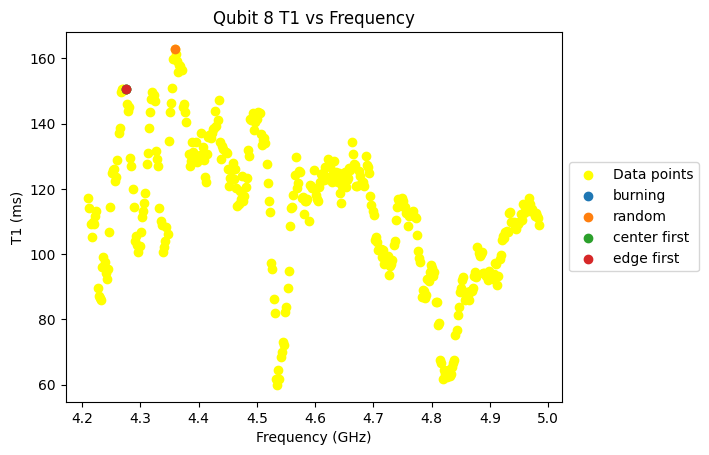

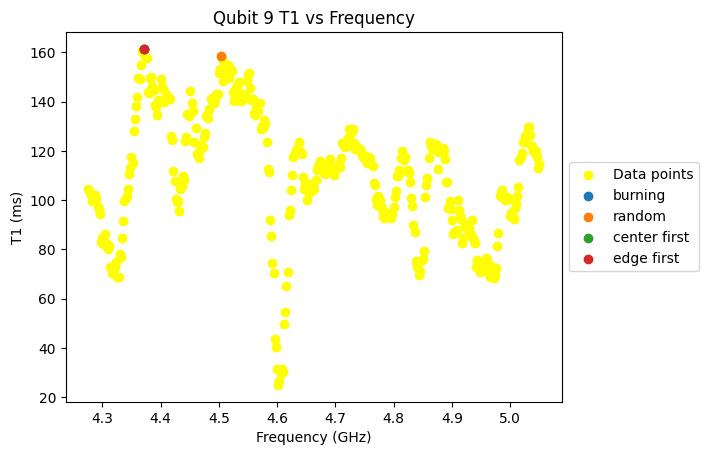

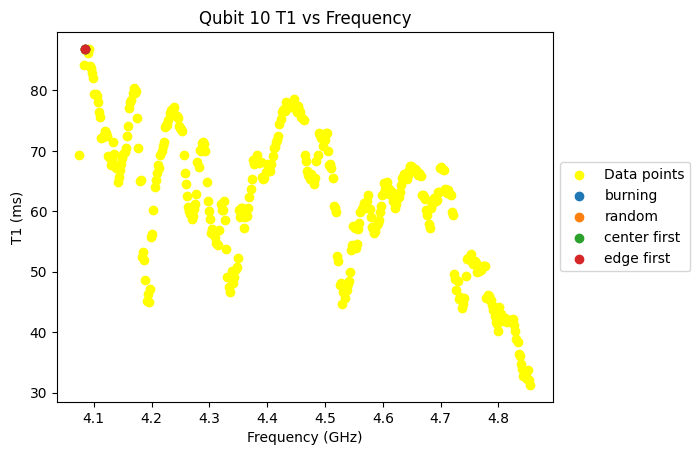

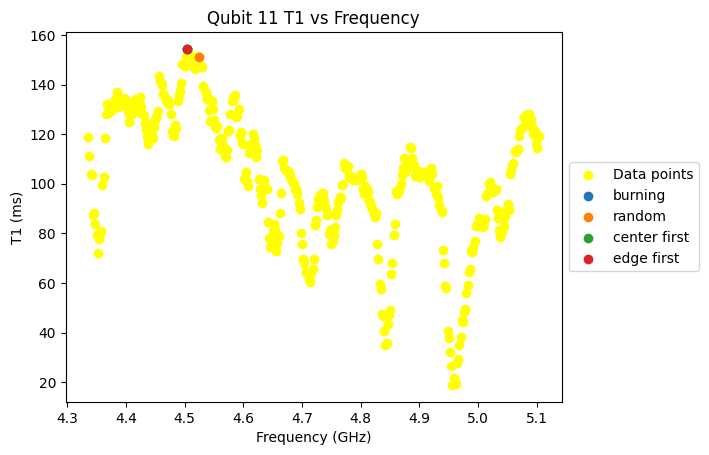

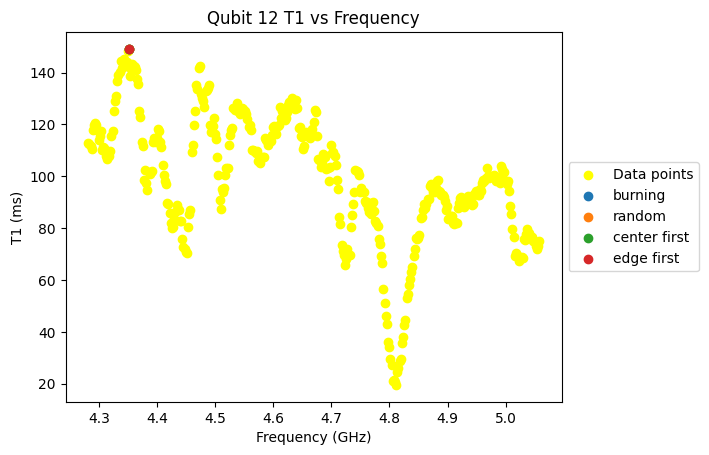

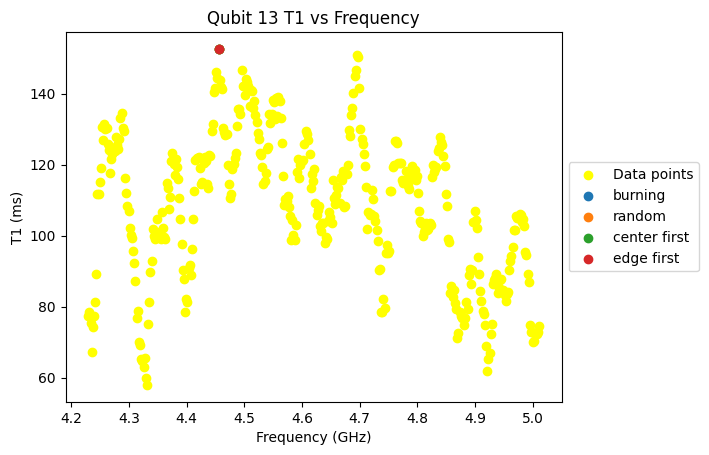

In [68]:
visualize_results(qdata_neighbor_smoothed, points, labels)

## Alpha * 2

execute order [4, 2, 7, 9, 13, 1, 5, 8, 11, 3, 6, 10, 12]
execute order [5, 11, 9, 12, 2, 1, 10, 4, 3, 8, 13, 7, 6]
execute order [4, 9, 2, 7, 13, 8, 5, 11, 1, 10, 6, 3, 12]
execute order [6, 3, 12, 10, 7, 9, 13, 2, 8, 5, 1, 11, 4]

burning
sum of t1:  1883.234
sum of t1 * delta x: 9.416 


random
sum of t1:  1883.234
sum of t1 * delta x: 9.416 


center first
sum of t1:  1883.234
sum of t1 * delta x: 9.416 


edge first
sum of t1:  1883.234
sum of t1 * delta x: 9.416 



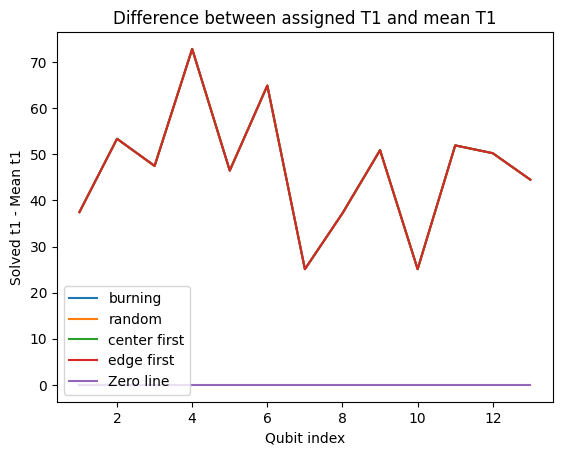

point [[[(np.float64(4.478), np.float64(146.08196))], [(np.float64(4.478), np.float64(146.08196))], [(np.float64(4.478), np.float64(146.08196))], [(np.float64(4.478), np.float64(146.08196))]], [[(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))]], [[(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))]], [[(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))]], [[(np.float64(4.2373), np.float64(138.53322000000003))], [(np.float64(4.2373), np.float64(138.53322000000003))], [(np.float64(4.2373), np.float64(138.53322000000003)

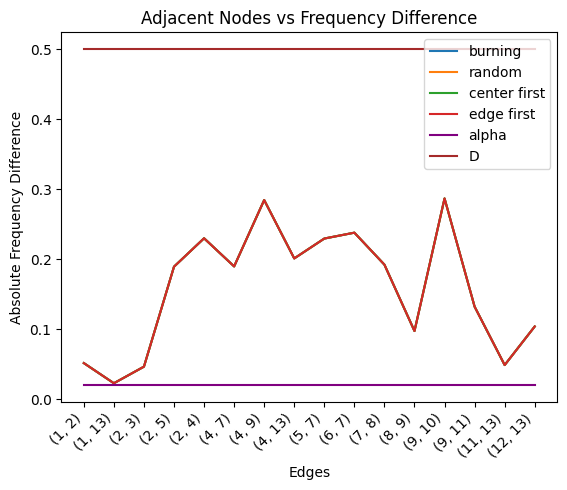

In [69]:
order_list = order_list = [None, "random", [4, 9, 2, 7, 13, 8, 5, 11, 1, 10, 6, 3, 12], [6, 3, 12, 10, 7, 9, 13, 2, 8, 5, 1, 11, 4]]
points = run_n_visualize(qdata_neighbor_smoothed, labels, order_list, params=(alpha*2, D))

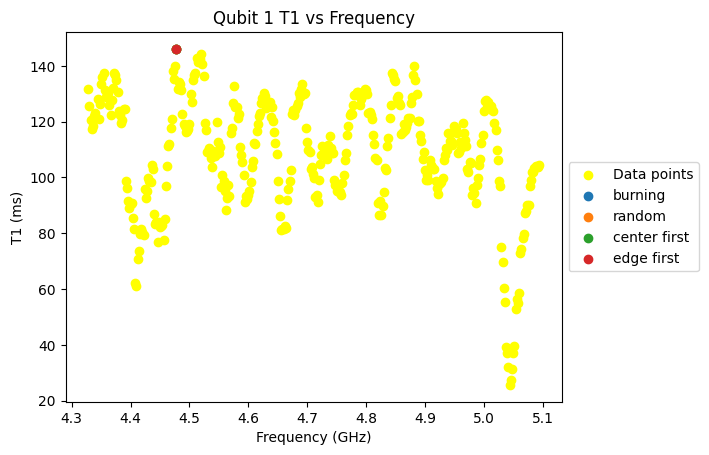

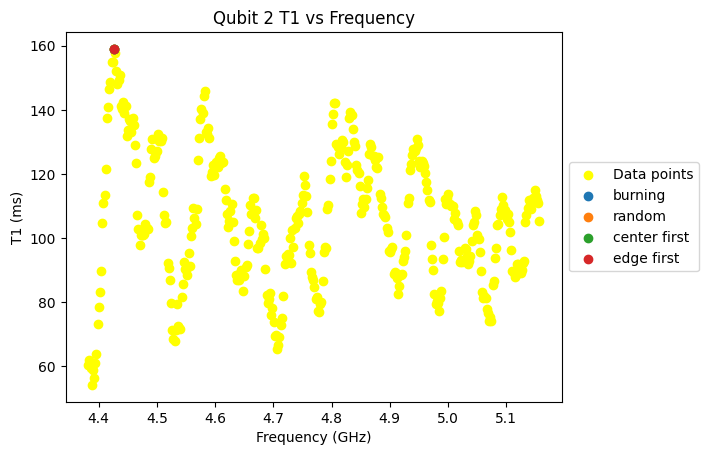

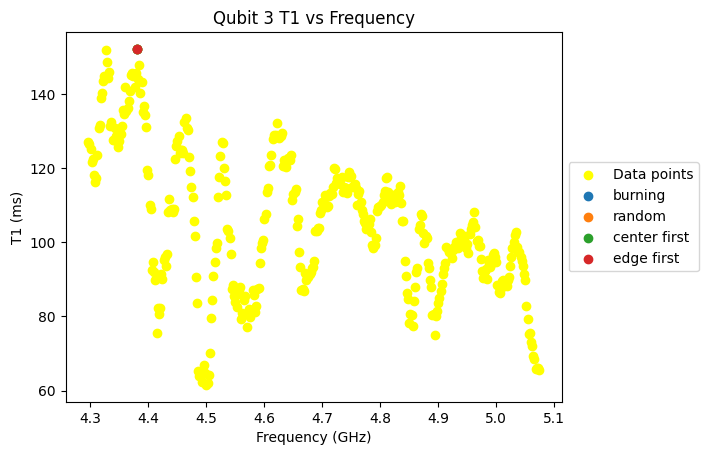

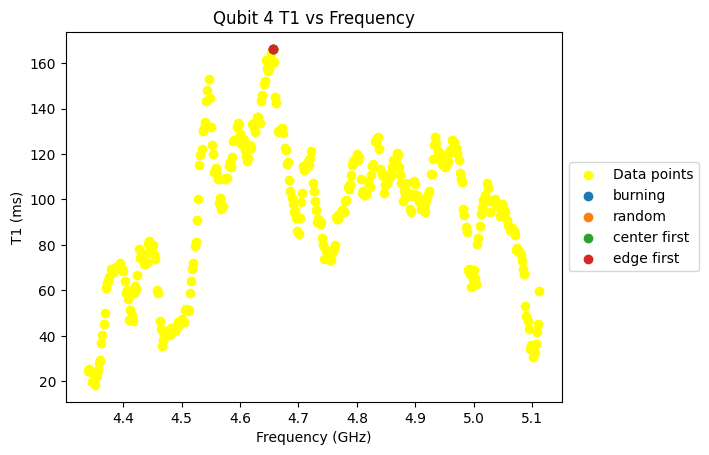

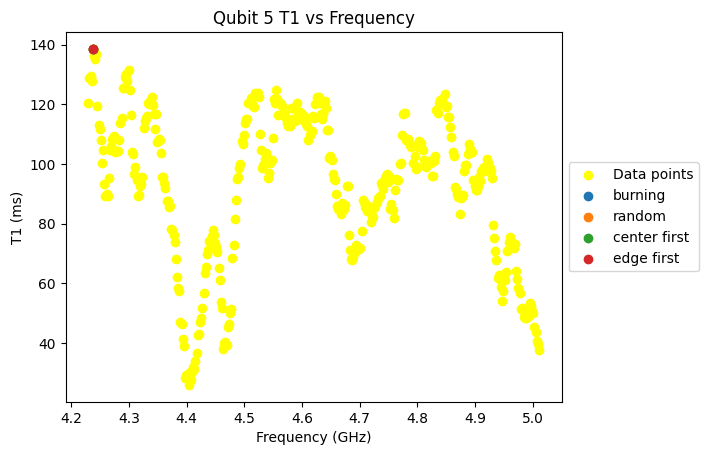

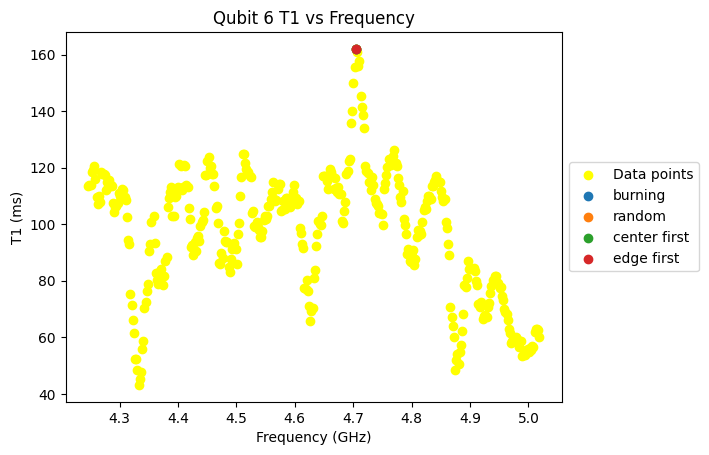

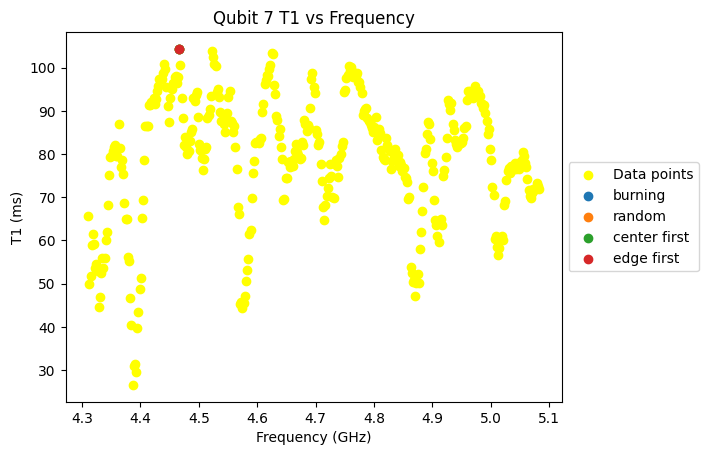

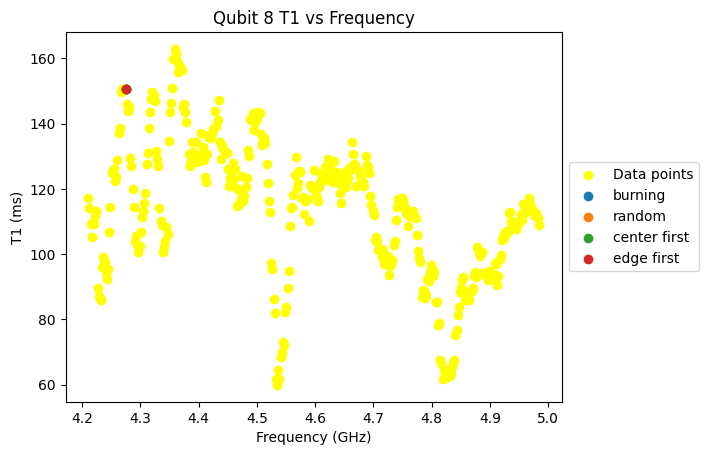

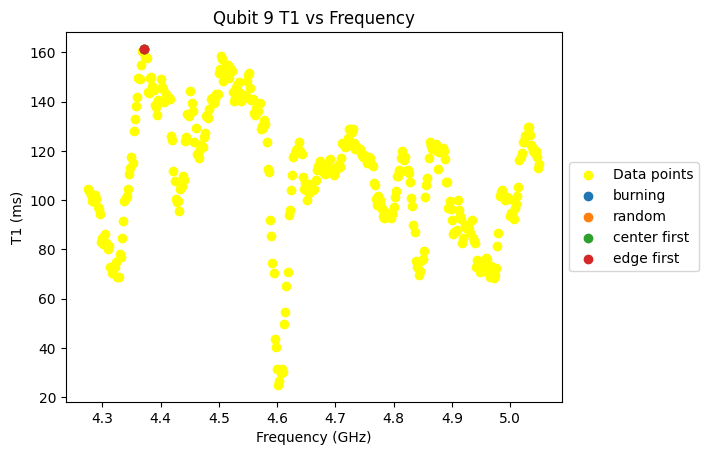

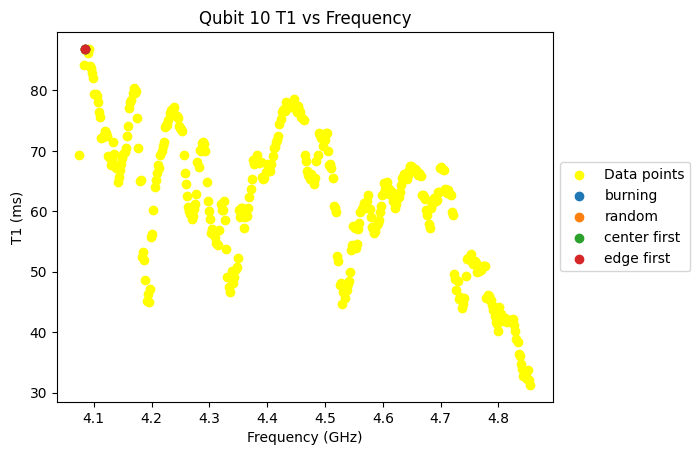

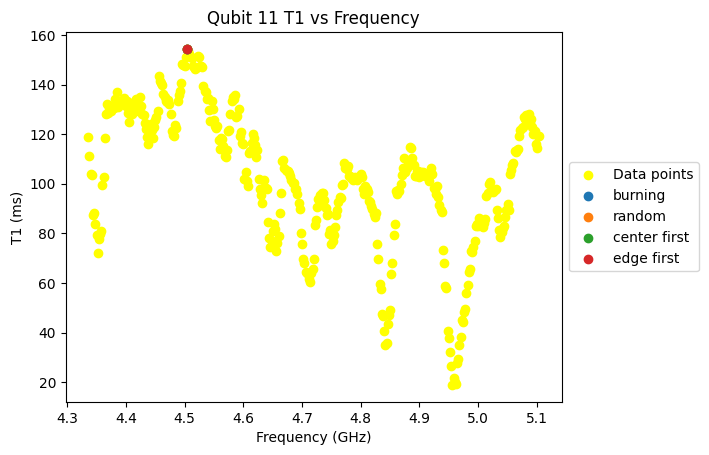

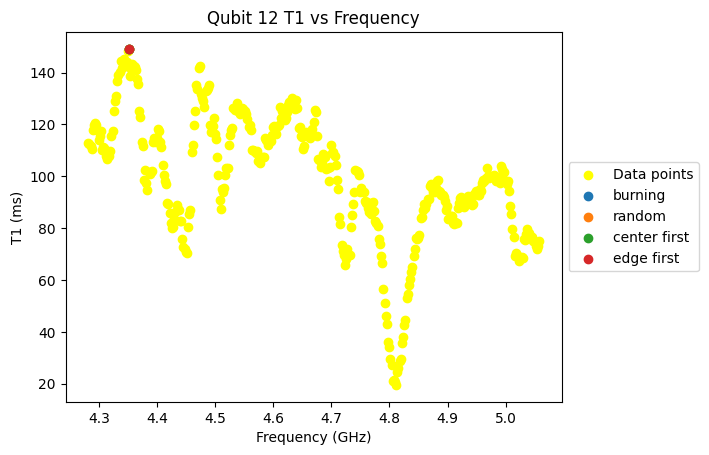

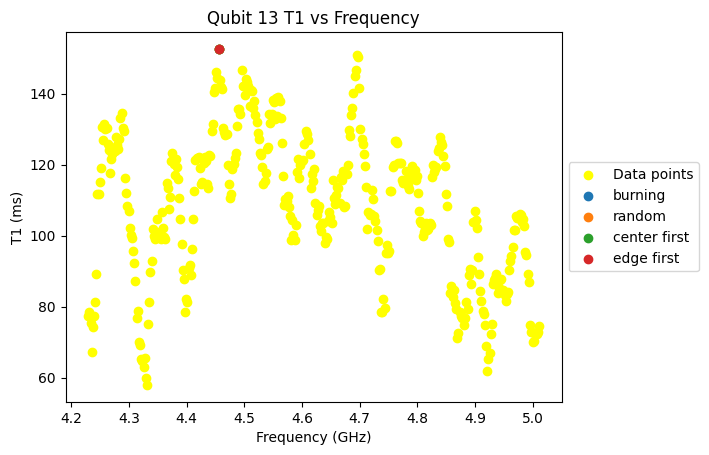

In [70]:
visualize_results(qdata_neighbor_smoothed, points, labels)

## Alpha * 3

execute order [4, 2, 7, 9, 13, 1, 5, 8, 11, 3, 6, 10, 12]
execute order [4, 7, 9, 2, 10, 3, 11, 1, 6, 8, 12, 5, 13]
execute order [4, 9, 2, 7, 13, 8, 5, 11, 1, 10, 6, 3, 12]
execute order [6, 3, 12, 10, 7, 9, 13, 2, 8, 5, 1, 11, 4]

burning
sum of t1:  1883.234
sum of t1 * delta x: 9.416 


random
sum of t1:  1883.234
sum of t1 * delta x: 9.416 


center first
sum of t1:  1883.234
sum of t1 * delta x: 9.416 


edge first
sum of t1:  1883.234
sum of t1 * delta x: 9.416 



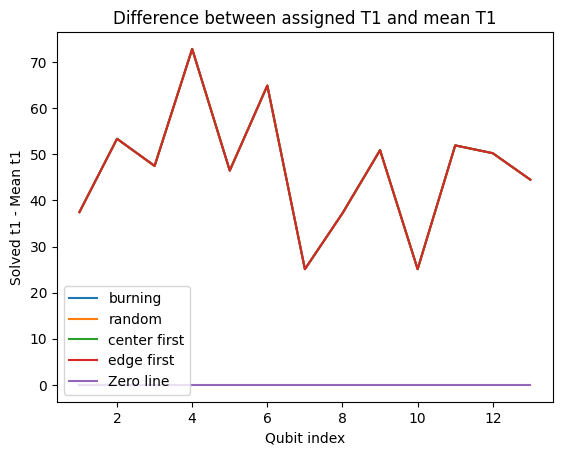

point [[[(np.float64(4.478), np.float64(146.08196))], [(np.float64(4.478), np.float64(146.08196))], [(np.float64(4.478), np.float64(146.08196))], [(np.float64(4.478), np.float64(146.08196))]], [[(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))]], [[(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))]], [[(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))]], [[(np.float64(4.2373), np.float64(138.53322000000003))], [(np.float64(4.2373), np.float64(138.53322000000003))], [(np.float64(4.2373), np.float64(138.53322000000003)

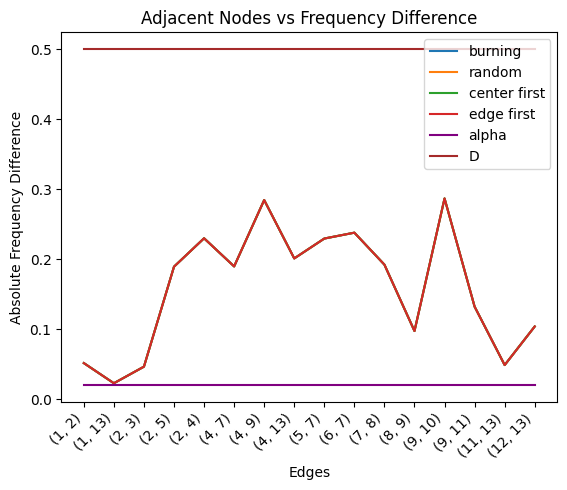

In [71]:
order_list = order_list = [None, "random", [4, 9, 2, 7, 13, 8, 5, 11, 1, 10, 6, 3, 12], [6, 3, 12, 10, 7, 9, 13, 2, 8, 5, 1, 11, 4]]
points = run_n_visualize(qdata_neighbor_smoothed, labels, order_list, params=(alpha*3, D))

## Alpha * 4

execute order [4, 2, 7, 9, 13, 1, 5, 8, 11, 3, 6, 10, 12]
execute order [8, 11, 12, 10, 5, 7, 6, 4, 1, 9, 3, 2, 13]
execute order [4, 9, 2, 7, 13, 8, 5, 11, 1, 10, 6, 3, 12]
execute order [6, 3, 12, 10, 7, 9, 13, 2, 8, 5, 1, 11, 4]

burning
sum of t1:  1883.234
sum of t1 * delta x: 9.416 


random
sum of t1:  1885.789
sum of t1 * delta x: 9.429 


center first
sum of t1:  1883.234
sum of t1 * delta x: 9.416 


edge first
sum of t1:  1883.234
sum of t1 * delta x: 9.416 



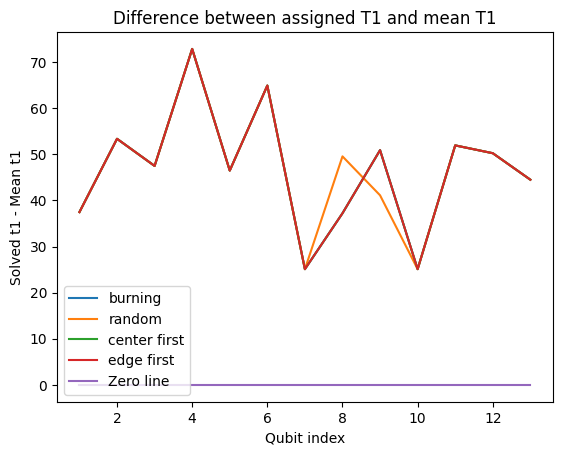

point [[[(np.float64(4.478), np.float64(146.08196))], [(np.float64(4.478), np.float64(146.08196))], [(np.float64(4.478), np.float64(146.08196))], [(np.float64(4.478), np.float64(146.08196))]], [[(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))]], [[(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))]], [[(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))]], [[(np.float64(4.2373), np.float64(138.53322000000003))], [(np.float64(4.2373), np.float64(138.53322000000003))], [(np.float64(4.2373), np.float64(138.53322000000003)

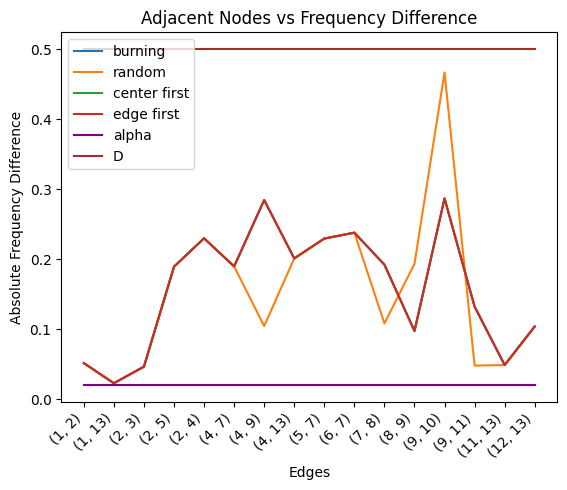

In [72]:
order_list = order_list = [None, "random", [4, 9, 2, 7, 13, 8, 5, 11, 1, 10, 6, 3, 12], [6, 3, 12, 10, 7, 9, 13, 2, 8, 5, 1, 11, 4]]
points = run_n_visualize(qdata_neighbor_smoothed, labels, order_list, params=(alpha*4, D))

## Alpha * 5

execute order [4, 2, 7, 9, 13, 1, 5, 8, 11, 3, 6, 10, 12]
execute order [4, 5, 6, 1, 3, 12, 2, 11, 9, 8, 10, 13, 7]
execute order [4, 9, 2, 7, 13, 8, 5, 11, 1, 10, 6, 3, 12]
execute order [6, 3, 12, 10, 7, 9, 13, 2, 8, 5, 1, 11, 4]

burning
sum of t1:  1883.234
sum of t1 * delta x: 9.416 


random
sum of t1:  1883.234
sum of t1 * delta x: 9.416 


center first
sum of t1:  1883.234
sum of t1 * delta x: 9.416 


edge first
sum of t1:  1883.234
sum of t1 * delta x: 9.416 



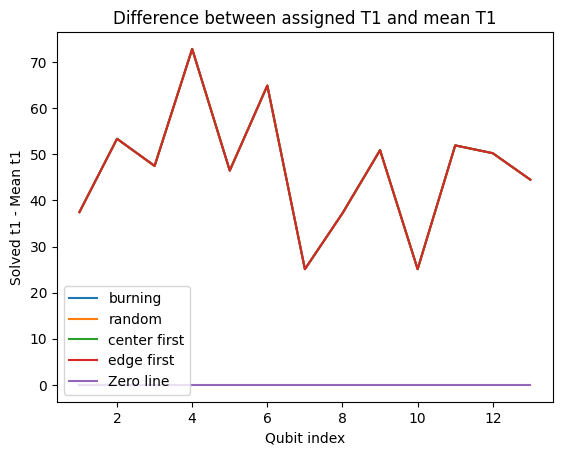

point [[[(np.float64(4.478), np.float64(146.08196))], [(np.float64(4.478), np.float64(146.08196))], [(np.float64(4.478), np.float64(146.08196))], [(np.float64(4.478), np.float64(146.08196))]], [[(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))], [(np.float64(4.4265), np.float64(159.01899090909092))]], [[(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))], [(np.float64(4.3801), np.float64(152.16943))]], [[(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))], [(np.float64(4.6563), np.float64(166.28220909090908))]], [[(np.float64(4.2373), np.float64(138.53322000000003))], [(np.float64(4.2373), np.float64(138.53322000000003))], [(np.float64(4.2373), np.float64(138.53322000000003)

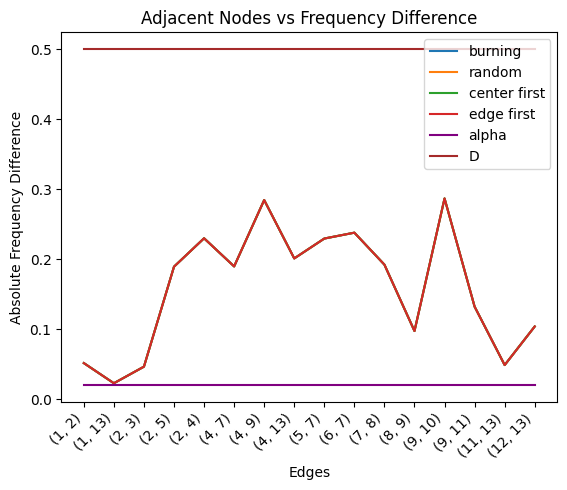

In [73]:
order_list = order_list = [None, "random", [4, 9, 2, 7, 13, 8, 5, 11, 1, 10, 6, 3, 12], [6, 3, 12, 10, 7, 9, 13, 2, 8, 5, 1, 11, 4]]
points = run_n_visualize(qdata_neighbor_smoothed, labels, order_list, params=(0.1, D))

## Compare Data v. Gradient Stable v. Neighbor Smooth

In [74]:
# for i in range(1, 14):
#     x = len(qdata_neighbor_smoothed[i][0]) - len(qdata_stable[i][0])
#     print(f"Qubit {i} neighbor smooth has {x} more points then gradient stable")

# print()
# for i in range(1, 13):
#     y = len(qdata_neighbor_smoothed[i][0]) - len(qdata_smoothed[i][0])
#     print(f"Qubit {i} neighbor smooth has {y} more points then smoothed data")

## Neighbor Smoothed v. Gradient Smooth

In [75]:
# # Visualize legal_freq_dots

# for i, (freq, t1) in qdata_neighbor_smoothed.items():
#     plt.scatter(freq, t1, color='yellow', label='Neighbor Smoothed')
#     plt.title(f'Qubit {i} T1 vs Frequency')

#     for x, y in legal_freq_dots[i]:
#         plt.scatter(x, y, color='blue')
#     plt.xlabel('Frequency (GHz)')
#     plt.ylabel('T1 (ms)')
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.show()

## Visualize Smooth Neighbor Points

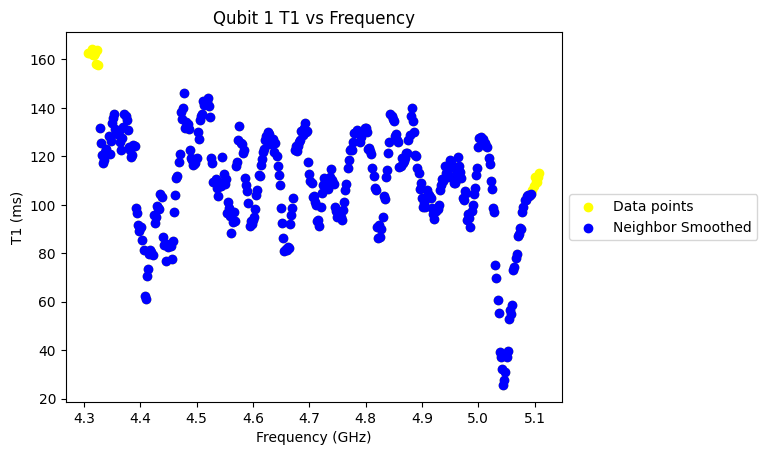

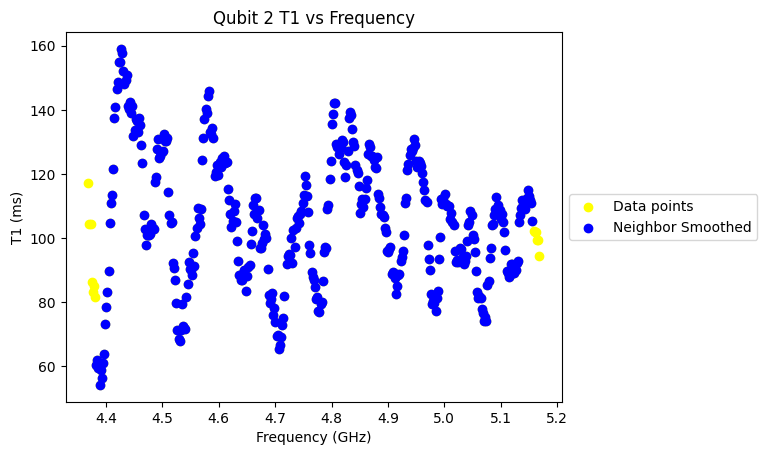

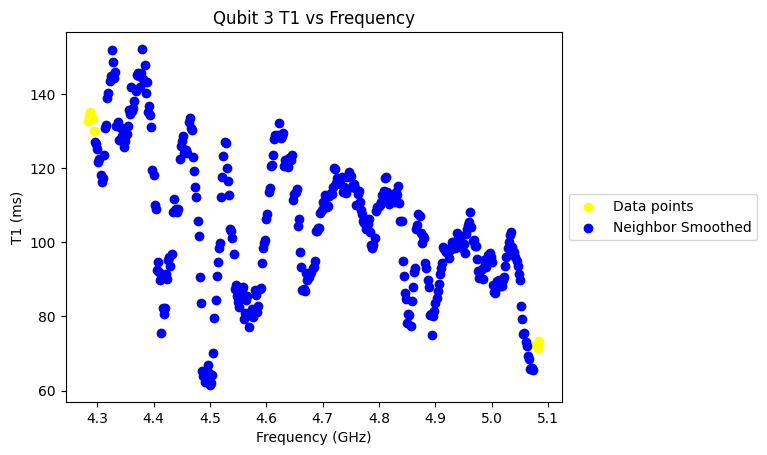

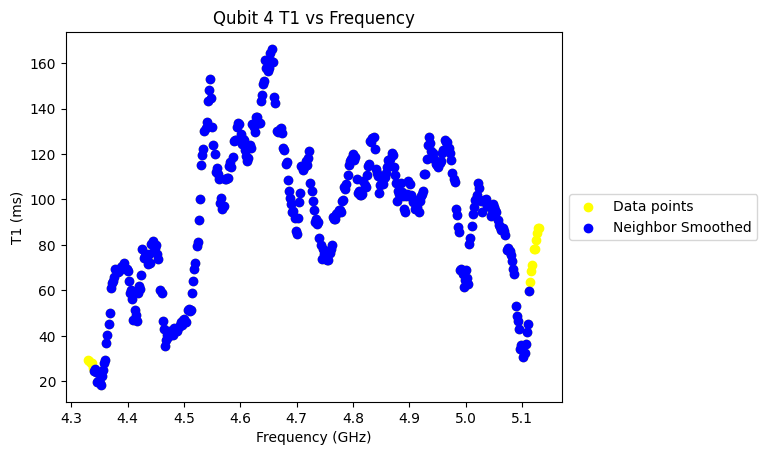

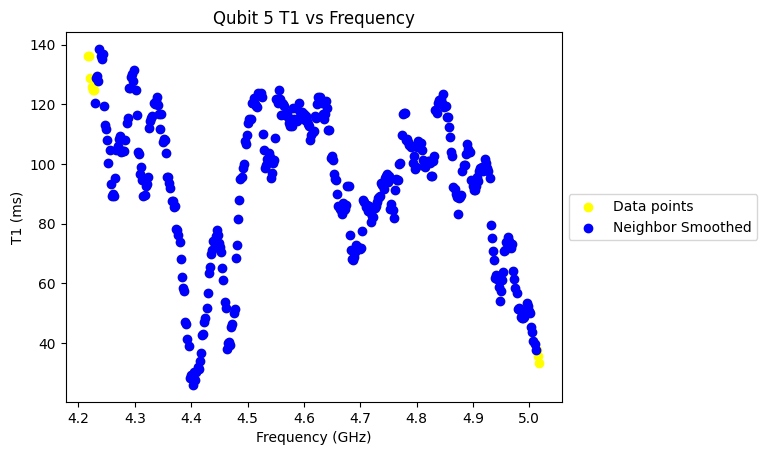

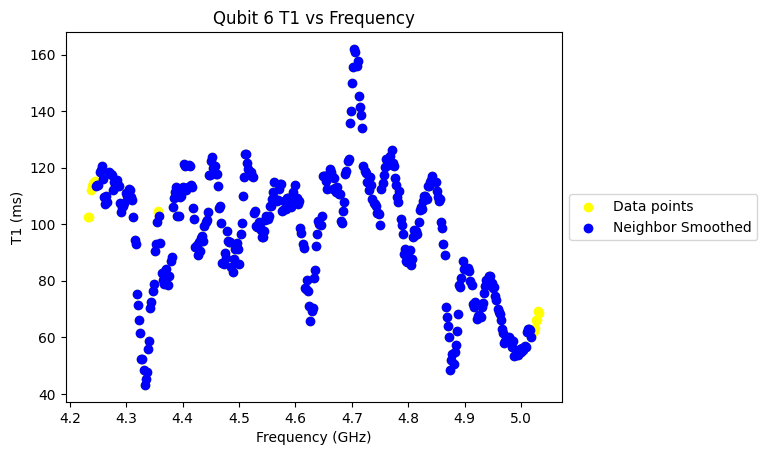

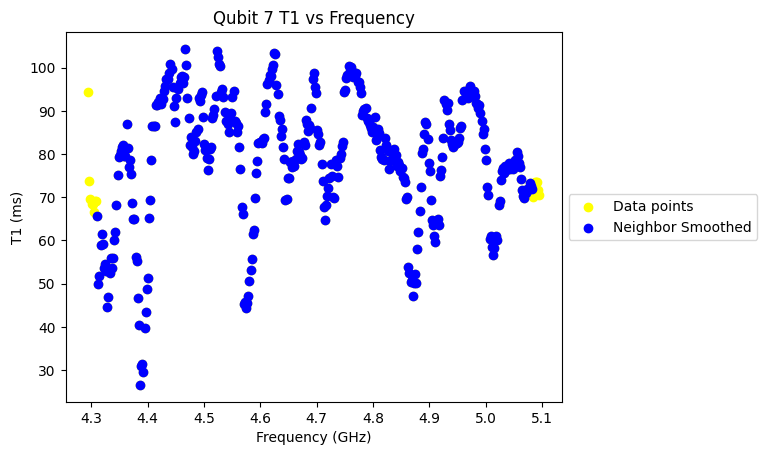

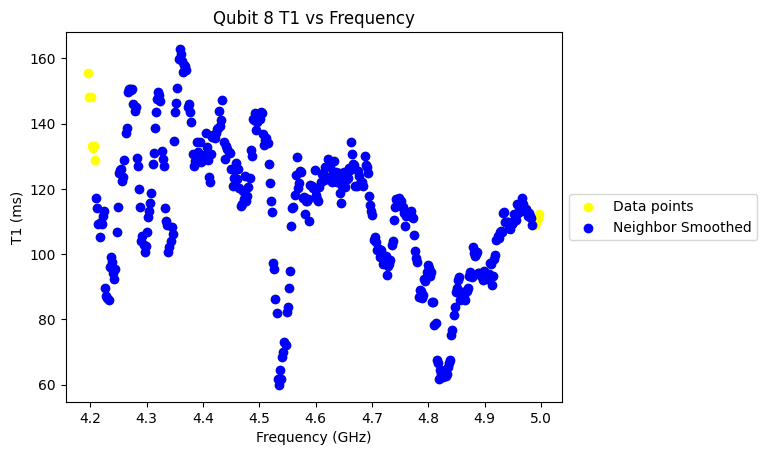

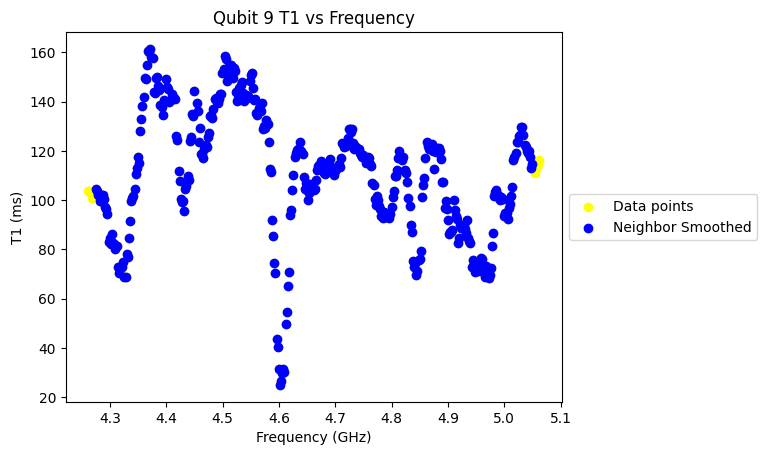

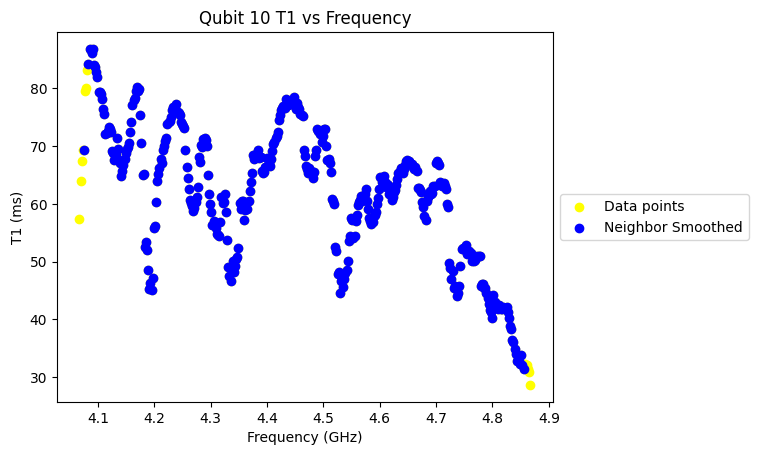

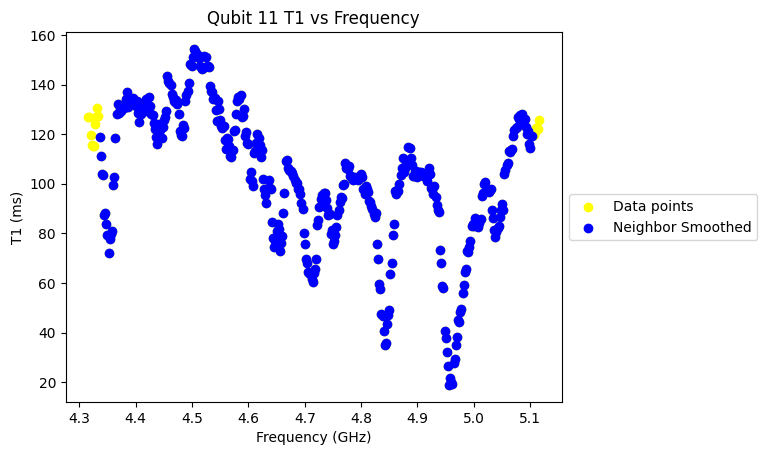

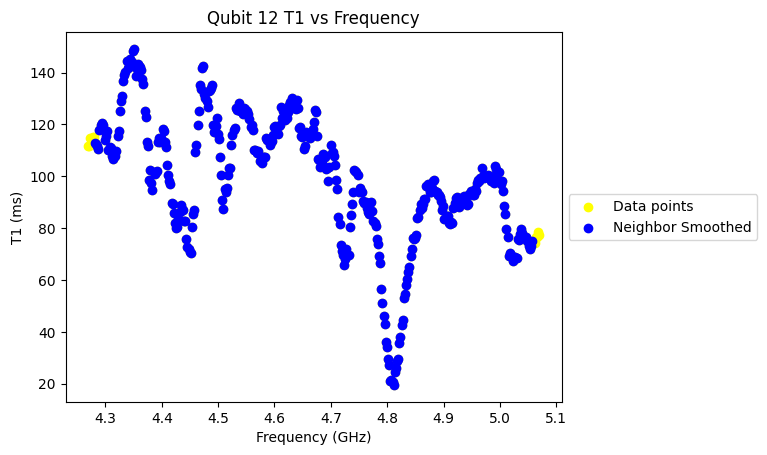

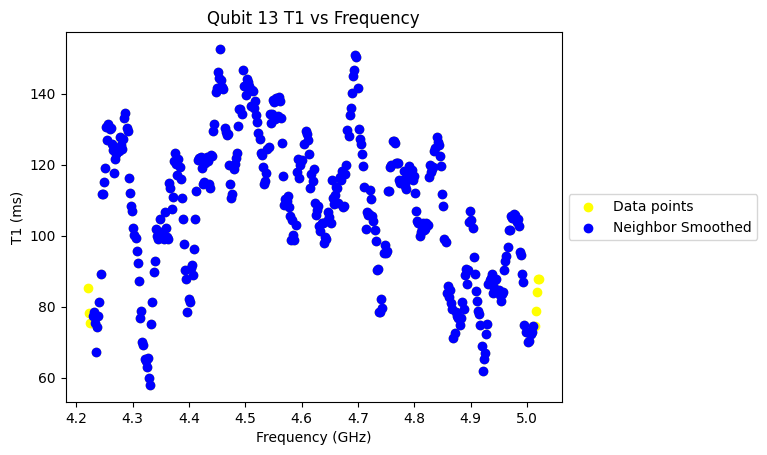

In [76]:
for i, (freq, t1) in qdata_smoothed.items():
    plt.scatter(freq, t1, color='yellow', label='Data points')
    plt.title(f'Qubit {i} T1 vs Frequency')

    plt.scatter(qdata_neighbor_smoothed[i][0], qdata_neighbor_smoothed[i][1], color='blue', label='Neighbor Smoothed')
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('T1 (ms)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()